In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit
from sklearn.utils import shuffle

In [2]:
# g = sns.FacetGrid(df, col="method")
# g.map_dataframe(sns.lineplot, x="x", y="y")
# g.add_legend()
# g.set_axis_labels("Iteration", "Objective Value")
# for ax in g.axes.flatten():
#     ax.grid(b=True, which='both')
# plt.show()

In [3]:
def random_Q(eta, psi, sigma_k, r, n=10, seed=1024):
    np.random.seed(seed)
    A = np.random.normal(size=(n, r))
    q, _ = np.linalg.qr(A) 
    E = np.concatenate([np.eye(r), np.zeros((r, n-r))], axis=1).T
    V = eta*q + (1-eta)*E
    diag_sigma = np.exp(np.random.uniform(size=r, low=np.log(1/sigma_k), high=0))
    if r > 1:
        diag_sigma[diag_sigma == diag_sigma.min()] = 1/sigma_k
        diag_sigma[diag_sigma == diag_sigma.max()] = 1
    Sigma = np.diag(diag_sigma)
    Q = V @ Sigma @ V.T + psi*np.ones((n, 1))@np.ones((n,1)).T
    Q = Q/np.max(np.diag(Q))
    return Q

In [4]:
def objective_function(w, Q):
    return 0.5*w.T @ Q @ w

In [5]:
# @njit()
def update(indices, w, Q, obj_val_score, epoch_num):
    n = len(w)
    for i, idx in enumerate(indices):
        wi_grad = Q[idx, :].T @ w
        w[idx] = w[idx] - wi_grad
        obj_val_score.append(0.5*w.T @ Q @ w)
    return w 

In [6]:
# @njit()
def accelerate_update(indices, w, y, v,
                      Q, sigma, gamma,
                      obj_val_score, epoch_num):
    n = len(w)
    for i, idx in enumerate(indices):
        b = (-1+sigma*gamma**2)/n
        gamma = (-b + np.sqrt(b**2 + 4*gamma**2))/2
        alpha = (n - gamma*sigma)/(gamma*(n**2 - sigma))
        beta = 1 - (gamma*sigma/n)
        y = alpha*v + (1-alpha)*w
        yi_grad = np.zeros(n) 
        yi_grad[idx] = Q[idx, :].T @ y 
        w = y - yi_grad
        obj_val_score.append(0.5*w.T @ Q @ w)
        v = beta*v + (1-beta)*y - gamma*yi_grad
        
    return w, y, v, gamma

In [7]:
def cd(Q, w, accelerate=False, tol=1e-6, maxiter=100,
       method='cyclic', seed=1024, sigma=0):
    
    np.random.seed(seed)
    n, _ = Q.shape
    w = w.copy()
    initial_obj_val = objective_function(w, Q)
    if accelerate:
        y = w.copy()
        v = w.copy()
        gamma = 0
    obj_val_score = []
    obj_val_score.append(initial_obj_val)
    for e in range(maxiter):
        if method == 'cyclic':
            indices = np.arange(n)
        elif method == "random":
            indices = np.random.choice(n, size=n, replace=True)
        elif method == "epoch":
            indices = shuffle(np.arange(n))
        if accelerate:
            w, y, v, gamma = accelerate_update(indices, w, y, v,
                                               Q,
                                               sigma, gamma,
                                               obj_val_score, e)
        else:
            w = update(indices, w, Q, obj_val_score, e)
        obj_val = objective_function(w, Q)
        ratio = obj_val/initial_obj_val
        if ratio < tol:
            break
    return w, obj_val_score

In [8]:
def gd(Q, w, eta, tol=1e-6, maxiter=100):
    
    obj_val_score = []
    w = w.copy()
    initial_obj_val = objective_function(w, Q)
    obj_val_score.append(initial_obj_val)
    for e in range(maxiter):
        
        w = w - eta*Q@w
        obj_val = objective_function(w, Q)
        obj_val_score.append(obj_val)
        ratio = obj_val/initial_obj_val
        if ratio < tol:
            break
    
    return w, obj_val_score
        

In [9]:
def theory_bound(L, Ro, fo, n):
    """
    L: Lipschitz constant of Q
    Ro: norm(w0)
    fo: objective value of w0
    n: number of variables
    n_iter: number of iteration to plot the bound
    """
    #Lmax is assume to equal 1
    #f* = 0
    So = Ro + fo/n**2
    rhs = fo * 1e-6
    random = 2*n*Ro**2/rhs
    cyclic = (4*n*(1 + n*L**2)*Ro**2)/rhs - 8
    acc = n/np.sqrt(rhs/So) - 1
    full = 2*L*Ro**2/rhs
    
    return pd.Series({'random': random,
                      'cyclic': cyclic,
                      'acc': acc,
                      'full': full})

In [10]:
def average_bound(df):
    return df.groupby(['method', 'trial'])['y'].count().groupby('method').mean()

In [11]:
def best_bound(df):
    return df.groupby(['method', 'trial'])['y'].count().groupby('method').min()

In [12]:
def worse_bound(df):
    return df.groupby(['method', 'trial'])['y'].count().groupby('method').max()

In [13]:
def experiment(Q, w, sigma, L, maxiter=5):

    seeds = [2048, 1972, 2034, 2022, 3021]
    x = [] 
    y = []
    method = []
    trial = []
    n = Q.shape[0]
    for i, seed in enumerate(seeds):
        if i==0:
            _, obj_val_score_cyclic = cd(Q, w, maxiter=maxiter, seed=seed)
            rep = len(obj_val_score_cyclic) - 1
            x = x + list(np.arange(rep))
            method = method + ['cyclic']*rep
            trial = trial + [i]*rep
            y = y + list(obj_val_score_cyclic[1:])
        
        
        _, obj_val_score_random = cd(Q, w, maxiter=maxiter, method="random", seed=seed)
        rep = len(obj_val_score_random) - 1
        x = x + list(np.arange(rep))
        method = method + ['random']*rep
        trial = trial + [i]*rep
        y = y + list(obj_val_score_random[1:])

        _, obj_val_score_random_acc = cd(Q, w, maxiter=maxiter, method="random", accelerate=True,
                                         sigma=max(0, sigma.real), seed=seed)
        rep = len(obj_val_score_random_acc) - 1
        x = x + list(np.arange(rep))
        method = method + ['accelerated random']*rep
        trial = trial + [i]*rep
        y = y + list(obj_val_score_random_acc[1:])
        
        
        if i==0:
            _, obj_val_score_gd = gd(Q, w, eta=1/L.real, maxiter=n*maxiter)
            rep = len(obj_val_score_gd) - 1
            x = x + list(np.arange(rep))
            method = method + ['gradient descent']*rep
            trial = trial + [i]*rep
            y = y + list(obj_val_score_gd[1:])
    
    df = pd.DataFrame({'x': x,
                       'y': y,
                       'method': method,
                       'trial':trial})
    return df

In [14]:
def theory_grid_search(n=10, r_step=1):
    theory_results = []
    for r in range(1, n+1, r_step):
        for sigma_k in np.arange(start=1, stop=111, step=10):
            for eta in np.arange(start=0, stop=1.1, step=0.1):
                for psi in np.exp(np.arange(start=-5, stop=0.5, step=0.5)):
                    Q = random_Q(eta=eta, psi=psi, sigma_k=sigma_k, r=r, n=n, seed=2012)
                    u, v = np.linalg.eig(Q)
                    L = np.round(np.max(u), 8)
                    w = np.random.normal(size=n)
                    Ro = np.linalg.norm(w)
                    fo = objective_function(w, Q)
                    series = theory_bound(L.real, Ro, fo, n)
                    theory_results.append(series)
    return theory_results

In [15]:
def experiment_grid_search(n=10, r_step=1):
    #run a grid search
    average_results = []
    best_results = []
    worse_results = []
    meta_data = []
    for r in range(1, n+1, r_step):
        for sigma_k in np.arange(start=1, stop=111, step=10):
            for eta in np.arange(start=0, stop=1.1, step=0.1):
                for psi in np.exp(np.arange(start=-5, stop=0.5, step=0.5)):
                    Q = random_Q(eta=eta, psi=psi, sigma_k=sigma_k, r=r, n=n, seed=2012)
                    u, v = np.linalg.eig(Q)
                    sigma = np.round(np.min(u), 8)
                    L = np.round(np.max(u), 8)
                    w = np.random.normal(size=n)
                    u, v = np.linalg.eig(Q)
                    sigma = np.round(np.min(u), 8)
                    L = np.round(np.max(u), 8)
                    Ro = np.linalg.norm(w)
                    fo = objective_function(w, Q)
                    df = experiment(Q, w, sigma, L, maxiter=5000)
                    series = pd.Series(dtype='float64')
                    series['sigma'] = sigma.real
                    series['L'] = L.real
                    series['eta'] = eta
                    series['r'] = r
                    series['psi'] = psi
                    series['sigma_k'] = sigma_k
                    meta_data.append(series)
                    series = average_bound(df)
                    average_results.append(series)
                    series = best_bound(df)
                    best_results.append(series)
                    series = worse_bound(df)
                    worse_results.append(series)
    return meta_data, average_results, best_results, worse_results
    

In [ ]:
theory_results = theory_grid_search(n=10, r_step=1)

In [ ]:
meta_data, average_results, best_results, worst_results = experiment_grid_search(n=10, r_step=1)

In [15]:
meta_data_df = pd.DataFrame(meta_data)

In [16]:
average_results_df = pd.DataFrame(average_results)

In [19]:
average_results_df = pd.merge(meta_data_df, average_results_df.reset_index(),
                              left_index=True, right_index=True).drop('index', axis=1)

In [21]:
worse_results_df = pd.DataFrame(worse_results)

In [22]:
worse_results_df = pd.merge(meta_data_df, worse_results_df.reset_index(),
                            left_index=True, right_index=True).drop('index', axis=1)

In [24]:
best_results_df = pd.DataFrame(best_results)

In [25]:
best_results_df = pd.merge(meta_data_df, best_results_df.reset_index(),
                           left_index=True, right_index=True).drop('index', axis=1)

In [2]:
os.chdir('/Users/vincent/Desktop/CO666 Final Project/Data')

In [3]:
# theory_df.to_csv('theory_df.csv')
theory_df = pd.read_csv('theory_df.csv')

In [4]:
# average_results_df.to_csv('average_results_df.csv')
average_results_df = pd.read_csv('average_results_df.csv')

In [5]:
# best_results_df.to_csv('best_results_df.csv')
best_results_df = pd.read_csv('best_results_df.csv')

In [6]:
# worse_results_df.to_csv('worse_results_df.csv')
worse_results_df = pd.read_csv('worse_results_df.csv')

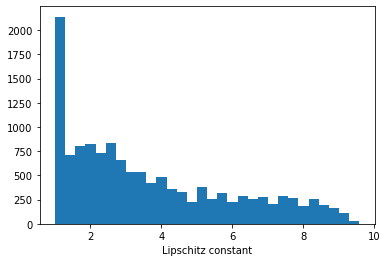

In [7]:
plt.hist(average_results_df['L'], bins=30)
plt.xlabel('Lipschitz constant')
plt.savefig('Lipschitz_constant.png')

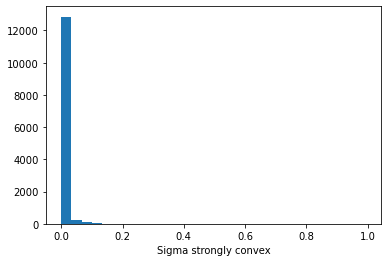

In [8]:
plt.hist(average_results_df['sigma'], bins=30)
plt.xlabel('Sigma strongly convex')
plt.savefig('sigma.png')

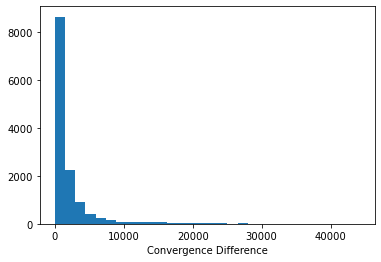

In [11]:
plt.hist(worse_results_df['random'] - best_results_df['random'], bins=30)
plt.xlabel('Convergence Difference')
plt.savefig('convergence.png')
plt.show()

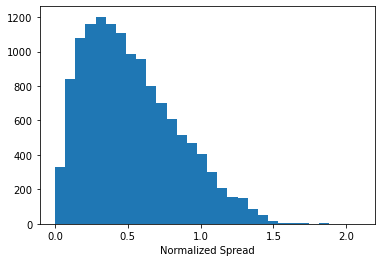

In [16]:
plt.hist((worse_results_df['random'] - best_results_df['random'])/average_results_df['random'], bins=30)
plt.xlabel('Normalized Spread')
plt.savefig('convergence.png')
plt.show()